In [310]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot
from simulations.analysis.plotting_helpers import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
df_ps_dict = load_data(["surface", "surface_matching"], prefixes=["", "matching_"])

## pfail vs pabort

In [10]:
from plotting_helpers import take_best_by_from_df_ps_dict

df_ps_best = take_best_by_from_df_ps_dict(
    df_ps_dict,
    exclude=(lambda by: "matching" in by or by in {"pred_llr", "detector_density"}),
    use_pfail_upper=False,
)

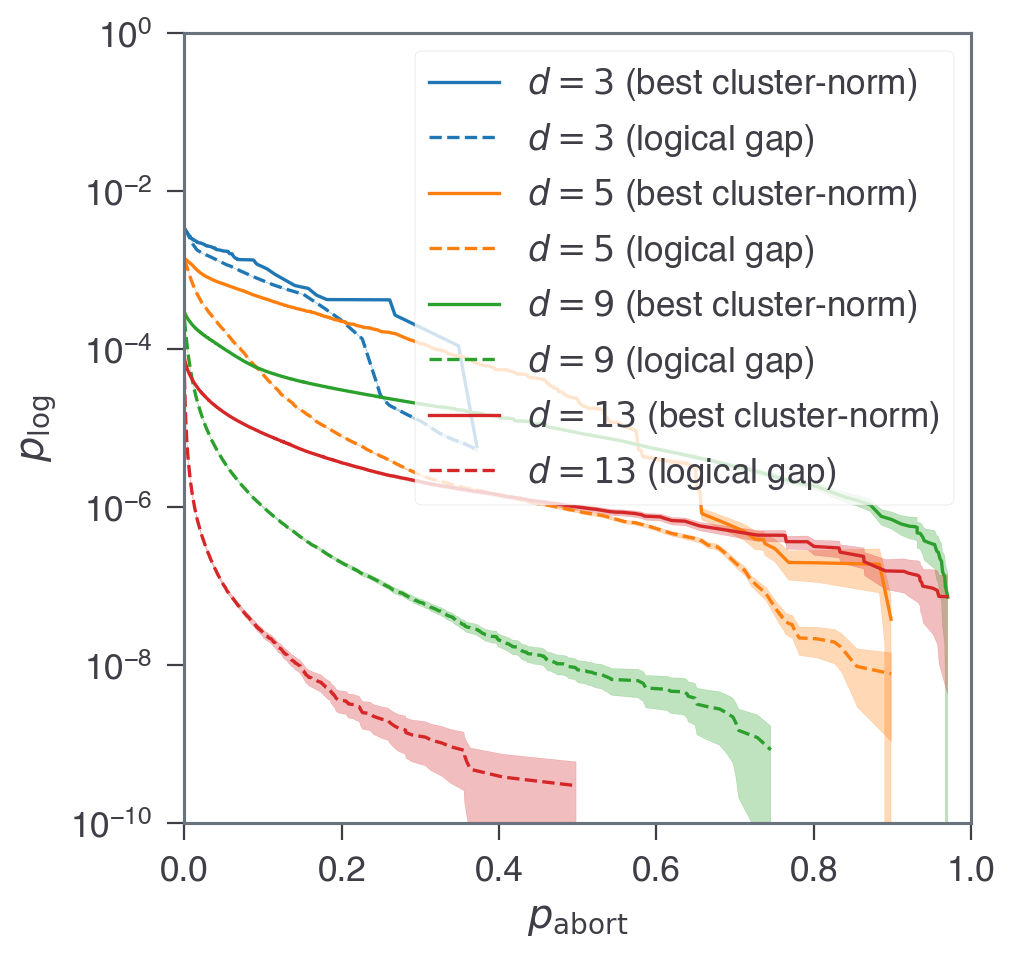

In [11]:
from plotting_helpers import get_lower_envelope

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

p = 0.005

dlist = df_ps_best.index.get_level_values("d").unique()
df_ps_matching_gap_all = df_ps_dict["matching_gap"]

for i_d, d in enumerate(dlist):
    df_ps_d = df_ps_best.loc[idx[d, d, p, :], :]
    p_abort = df_ps_d.index.get_level_values("p_abort").values
    p_fail = df_ps_d["p_fail"].values / d
    delta_p_fail = df_ps_d["delta_p_fail"].values / d
    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i_d),
        label=rf"$d={d}$ (best cluster-norm)",
        ax=ax,
    )

    try:
        df_ps_matching_gap = df_ps_matching_gap_all.loc[idx[d, d, p, :], :]
    except KeyError:
        continue
    df_ps_matching_gap = get_lower_envelope(df_ps_matching_gap)
    p_abort = df_ps_matching_gap["p_abort"].values
    p_fail = df_ps_matching_gap["p_fail"].values / d
    delta_p_fail = df_ps_matching_gap["delta_p_fail"].values / d
    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i_d),
        label=rf"$d={d}$ (logical gap)",
        linestyle="--",
        ax=ax,
    )

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{log}$")

fig.tight_layout()

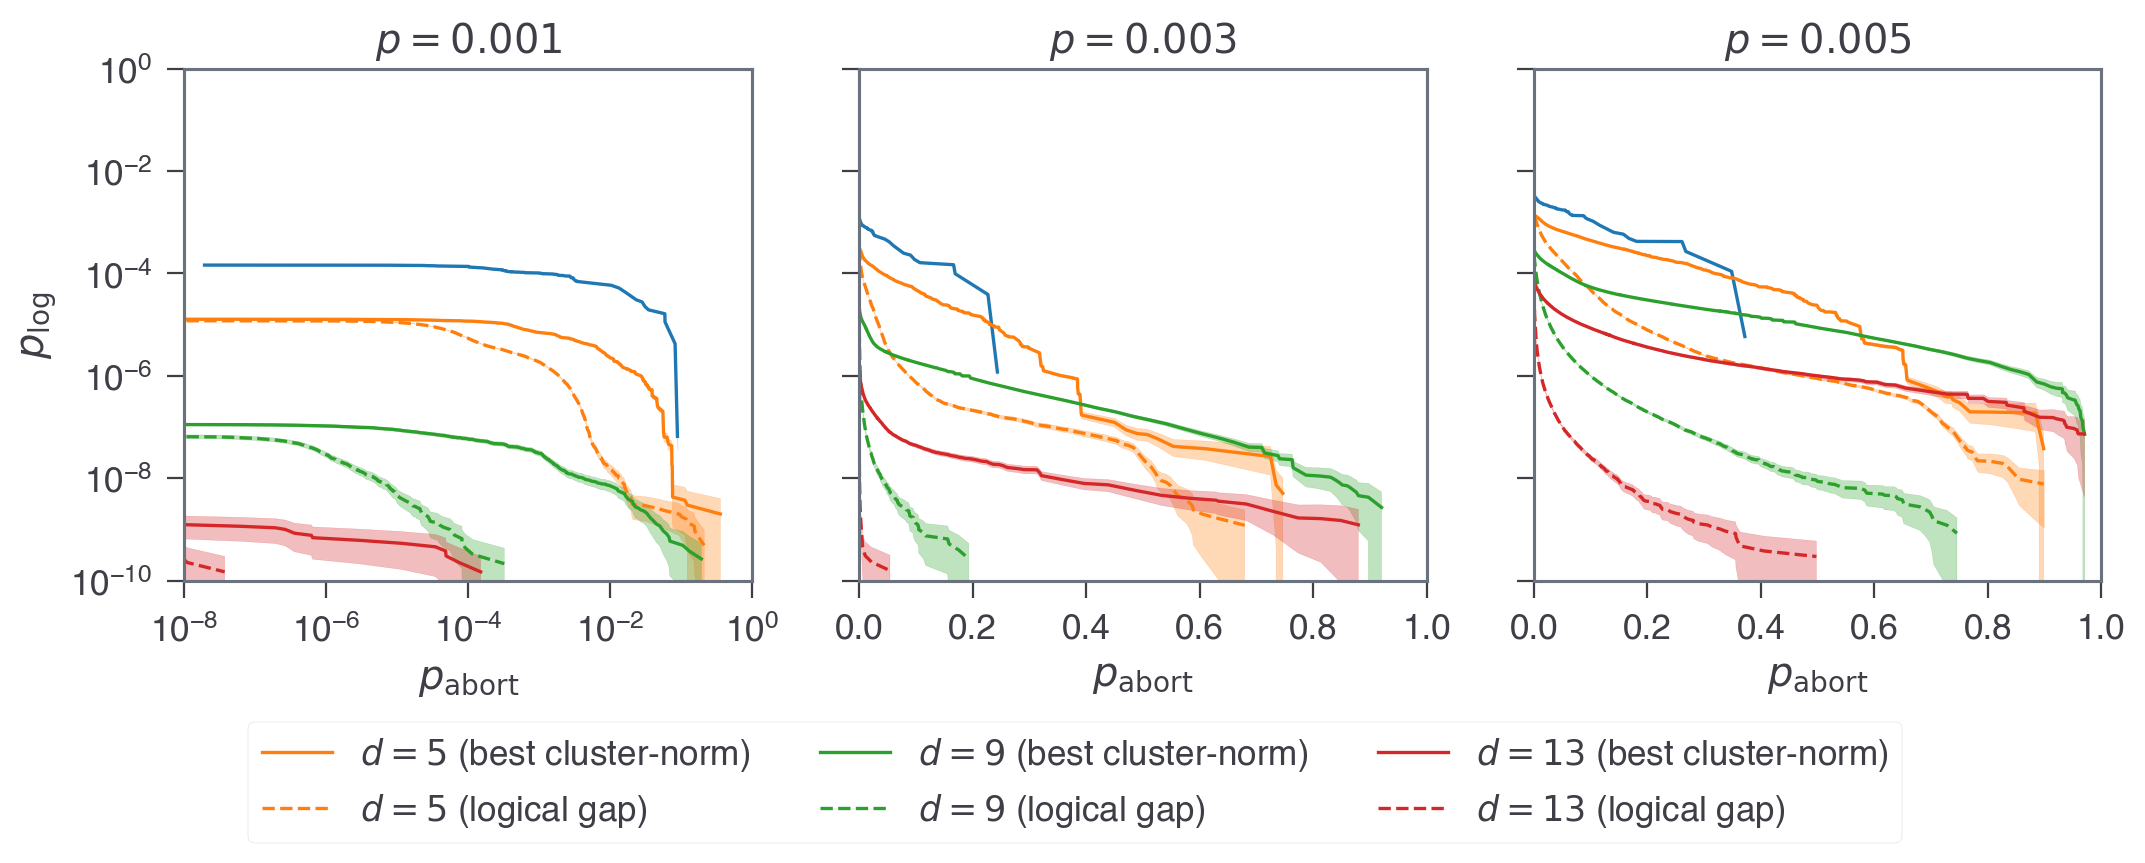

In [178]:
from plotting_helpers import get_lower_envelope, error_band_plot

fig, axes = plt.subplots(1, 3, figsize=(DFT_FIG_WIDTH_WIDE, 4), sharey=True)

p_values = [0.001, 0.003, 0.005]

dlist = df_ps_best.index.get_level_values("d").unique()
df_ps_matching_gap_all = df_ps_dict["matching_gap"]

# Create legend handles and labels
legend_handles = []
legend_labels = []

for i_p, p in enumerate(p_values):
    ax = axes[i_p]

    for i_d, d in enumerate(dlist):
        df_ps_d = df_ps_best.loc[idx[d, d, p, :], :]
        p_abort = df_ps_d.index.get_level_values("p_abort").values
        p_fail = df_ps_d["p_fail"].values / d
        delta_p_fail = df_ps_d["delta_p_fail"].values / d
        line1 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i_d),
            label=rf"$d={d}$ (best cluster-norm)",
            ax=ax,
        )

        try:
            df_ps_matching_gap = df_ps_matching_gap_all.loc[idx[d, d, p, :], :]
        except KeyError:
            continue
        df_ps_matching_gap = get_lower_envelope(df_ps_matching_gap)
        p_abort = df_ps_matching_gap["p_abort"].values
        p_fail = df_ps_matching_gap["p_fail"].values / d
        delta_p_fail = df_ps_matching_gap["delta_p_fail"].values / d
        line2 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i_d),
            label=rf"$d={d}$ (logical gap)",
            linestyle="--",
            ax=ax,
        )

        # Collect legend handles and labels only from the first subplot
        if i_p == 0:
            legend_handles.extend([line1[0], line2[0]])
            legend_labels.extend(
                [rf"$d={d}$ (best cluster-norm)", rf"$d={d}$ (logical gap)"]
            )

    if i_p == 0:
        ax.set_xscale("log")
        ax.set_xlim(1e-8, 1)
    else:
        ax.set_xlim(0, 1)
    ax.set_yscale("log")
    ax.set_ylim(1e-10, 1)
    ax.set_xlabel(r"$p_\mathrm{abort}$")
    ax.set_title(f"$p = {p}$")

    if i_p == 0:
        ax.set_ylabel(r"$p_\mathrm{log}$")

# Add legend below the figure with 3 columns
fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)

fig.tight_layout()
plt.subplots_adjust(bottom=0.25)

logical error rate vs spacetime cost (code distance & abort rate) at a physical error rate
or vs footprint (space cost)

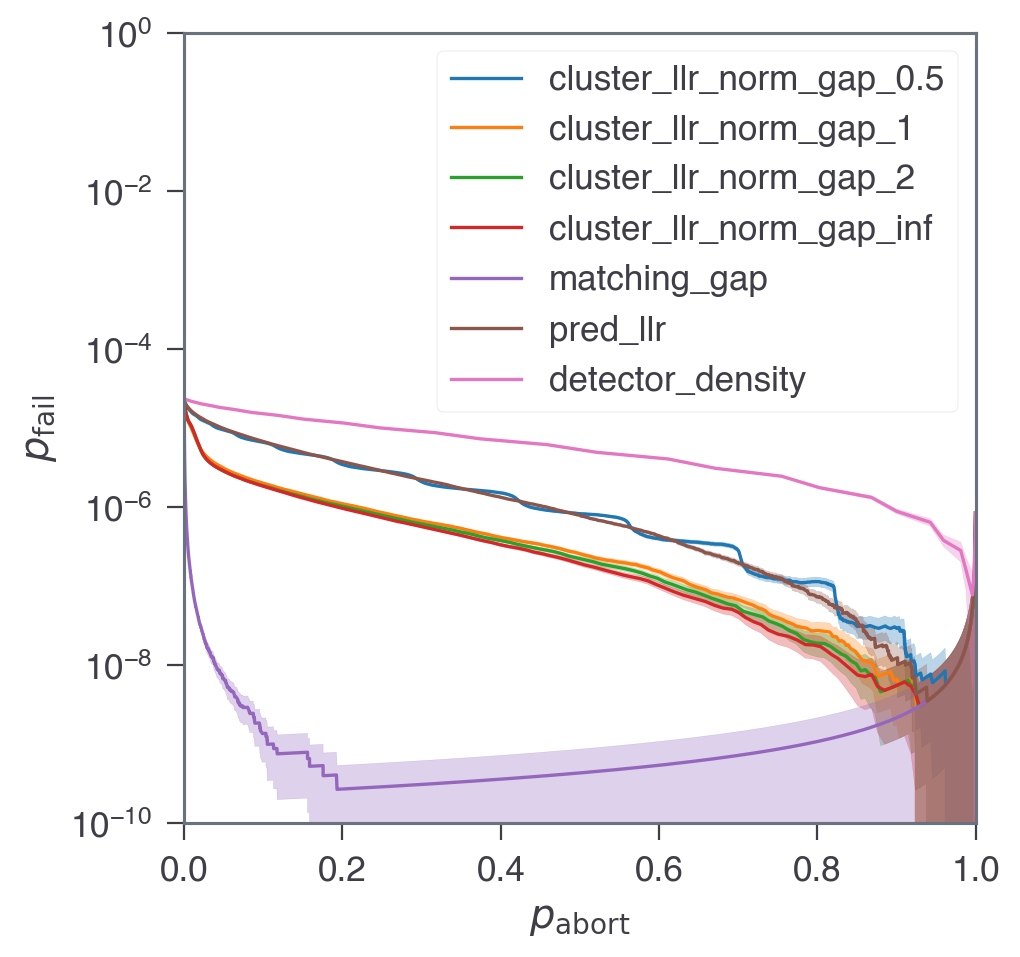

In [337]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

d = T = 9
p = 3e-3

# Create ordered list of keys
ordered_keys = []

# First, add cluster_llr_norm_gap keys in ascending order of i (as float)
cluster_keys = [key for key in df_ps_dict.keys() if "cluster_llr_norm_gap" in key]
# Sort by extracting the number after 'cluster_llr_norm_gap_' as float
cluster_keys.sort(
    key=lambda x: (
        float(x.split("_")[-1])
        if x.split("_")[-1].replace(".", "").isdigit()
        else float("inf")
    )
)
ordered_keys.extend(cluster_keys)

# Then add the other keys in specified order
for key in ["matching_gap", "pred_llr", "detector_density"]:
    if key in df_ps_dict:
        ordered_keys.append(key)

i = 0
data_plots = {}
for by in ordered_keys:
    df_ps_all = df_ps_dict[by]
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps_all.loc[idx[d, T, p, :], :]

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

relation to BP convergence

0: matching_gap (1.07e-09 ± 1.07e-09)
1: cluster_llr_norm_2 (1.99e-06 ± 1.98e-07)
2: cluster_llr_norm_gap_inf (2.20e-06 ± 2.16e-07)
3: cluster_llr_norm_gap_2 (2.53e-06 ± 2.32e-07)
4: cluster_llr_norm_gap_1 (2.77e-06 ± 2.42e-07)
5: cluster_llr_norm_1 (2.77e-06 ± 2.42e-07)
6: pred_llr (8.11e-06 ± 4.16e-07)
7: cluster_llr_norm_gap_0.5 (9.70e-06 ± 4.55e-07)
8: matching_pred_llr (1.03e-05 ± 1.48e-07)
9: cluster_llr_norm_0.5 (1.41e-05 ± 5.49e-07)
10: cluster_llr_norm_inf (2.27e-05 ± 3.98e-07)
11: matching_detector_density (4.14e-05 ± 2.84e-07)
12: detector_density (5.37e-05 ± 1.02e-06)


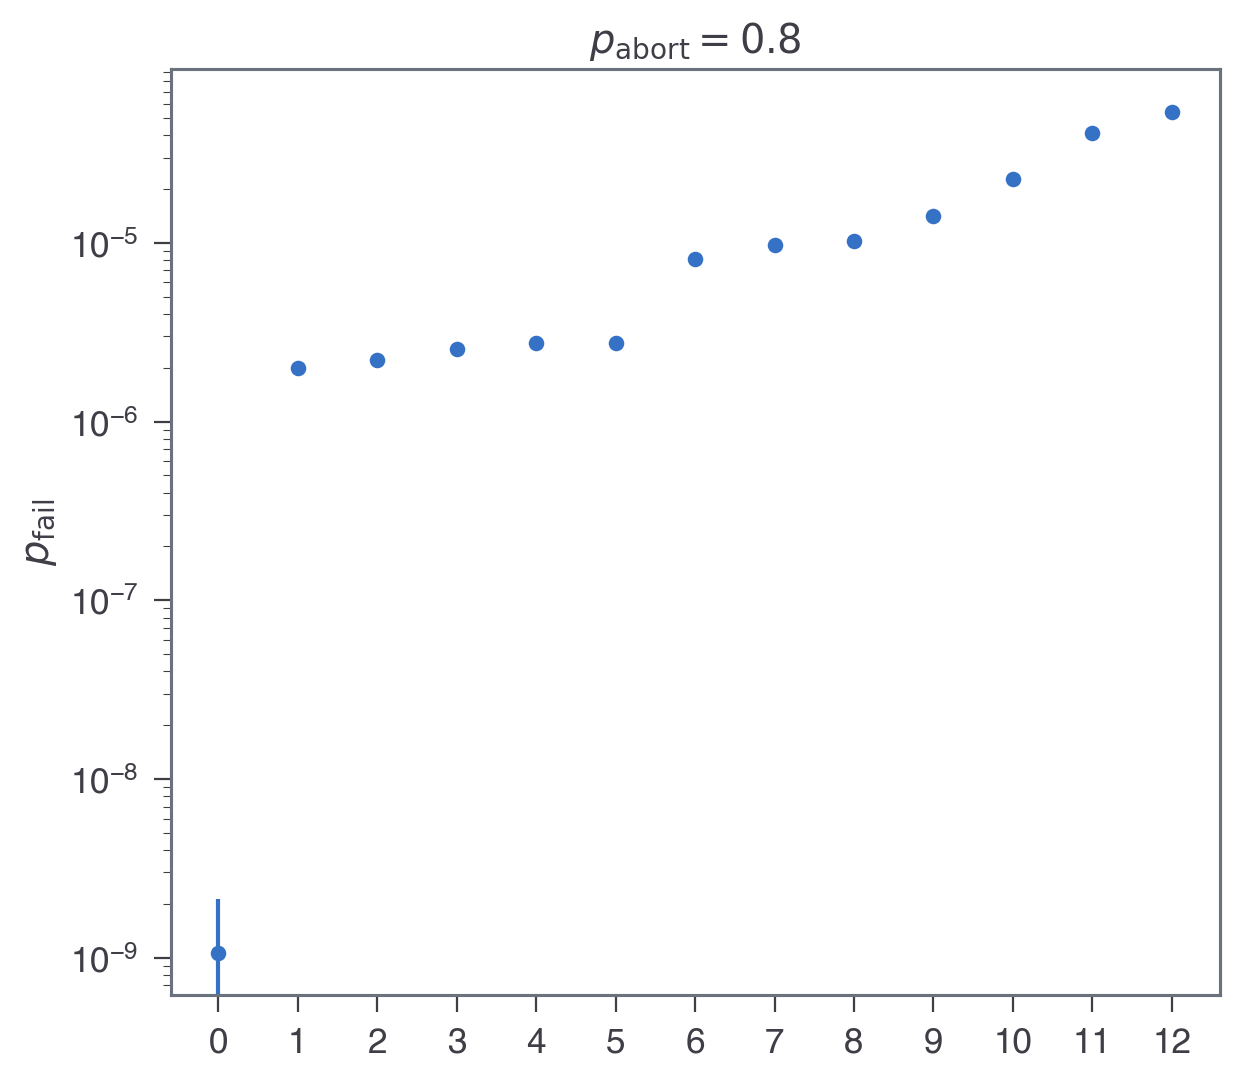

In [193]:
target = 0.8
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()

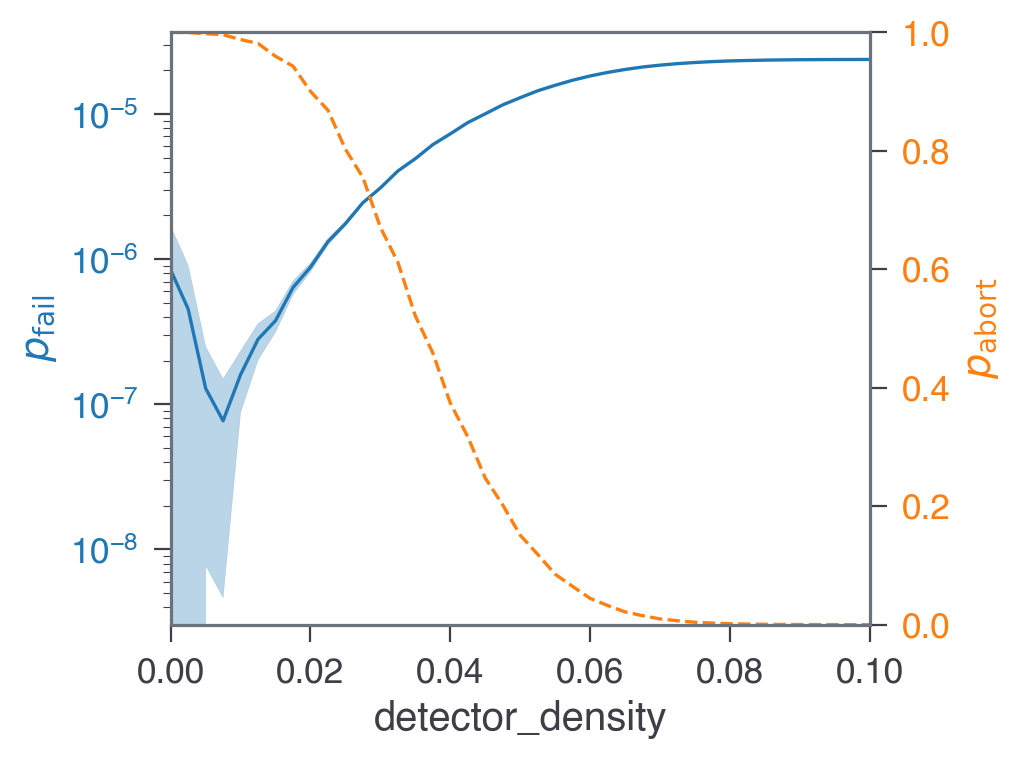

In [340]:
d = T = 9
p = 0.003
by = "detector_density"

df_ps = df_ps_dict[by].loc[idx[d, T, p, :], :]

x_vals = df_ps.index.get_level_values(3).values
p_fail = df_ps["p_fail"].values / T
delta_p_fail = df_ps["delta_p_fail"].values / T
p_abort = df_ps["p_abort"].values

fig, ax1 = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

color1 = COLORS(0)
color2 = COLORS(1)

# ax1.plot(x_vals, p_fail, color=color1, label="p_fail")
error_band_plot(x_vals, p_fail, delta_p_fail, ax=ax1, color=color1)
ax1.set_ylabel(r"$p_\mathrm{fail}$", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xlabel(by)
ax1.set_yscale("log")
ax1.set_xlim(0, 0.1)

ax2 = ax1.twinx()
ax2.plot(x_vals, p_abort, color=color2, label="p_abort", linestyle="--")
ax2.set_ylabel(r"$p_\mathrm{abort}$", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)
# ax2.set_yscale("log")
ax2.set_ylim(0, 1)

fig.tight_layout()

In [342]:
"""
벤치마킹 스크립트
----------------
• strict_diameter : subset으로 유도된 subgraph에서 diameter() 호출
• loose_diameter  : 전체 그래프 위에서 distances(source=subset,target=subset)로 최댓값 계산
• 그래프 크기 N, subset 크기 k 를 바꿔가며 속도‧메모리 측정
"""

import igraph as ig
import random, time, tracemalloc, statistics as st

# ---------- 실험 파라미터 ----------
N = 100_000  # 전체 vertex 수 (그래프 규모)
avg_deg = 6  # 원하는 평균 차수 → p = avg_deg / (N-1)
subset_szs = [20, 50, 100, 200, 500]
n_repeats = 3  # 각 케이스 반복 횟수
# -----------------------------------

p = avg_deg / (N - 1)
g = ig.Graph.Erdos_Renyi(n=N, p=p)  # 무가중치, 연결성 꽤 높음


def strict_diameter(g, subset):
    return g.induced_subgraph(subset).diameter()


def loose_diameter(g, subset):
    dist = g.distances(subset, subset)
    return max(d for row in dist for d in row if d != float("inf"))


def bench(fn, g, subset):
    tracemalloc.start()
    t0 = time.perf_counter()
    _ = fn(g, subset)
    dt = time.perf_counter() - t0
    cur, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return dt, peak / 1024 / 1024  # MB


print(f"# vertices = {N}, avg_deg ≈ {avg_deg}\n")
print("subset_size\tstrict_time(s)\tstrict_mem(MB)\tloose_time(s)\tloose_mem(MB)")

for k in subset_szs:
    ts, ms, tl, ml = [], [], [], []
    for _ in range(n_repeats):
        subset = random.sample(range(N), k)
        dt, m = bench(strict_diameter, g, subset)
        ts.append(dt)
        ms.append(m)
        dt, m = bench(loose_diameter, g, subset)
        tl.append(dt)
        ml.append(m)
    print(
        f"{k}\t\t{st.mean(ts):.4f}\t\t{st.mean(ms):.2f}\t\t{st.mean(tl):.4f}\t\t{st.mean(ml):.2f}"
    )

# vertices = 100000, avg_deg ≈ 6

subset_size	strict_time(s)	strict_mem(MB)	loose_time(s)	loose_mem(MB)
20		0.0001		0.00		0.0772		0.00
50		0.0002		0.00		0.1843		0.02
100		0.0002		0.00		0.3544		0.08
200		0.0003		0.00		0.7188		0.32
500		0.0003		0.00		1.8404		1.96


## pfail vs p for a fixed abort rate

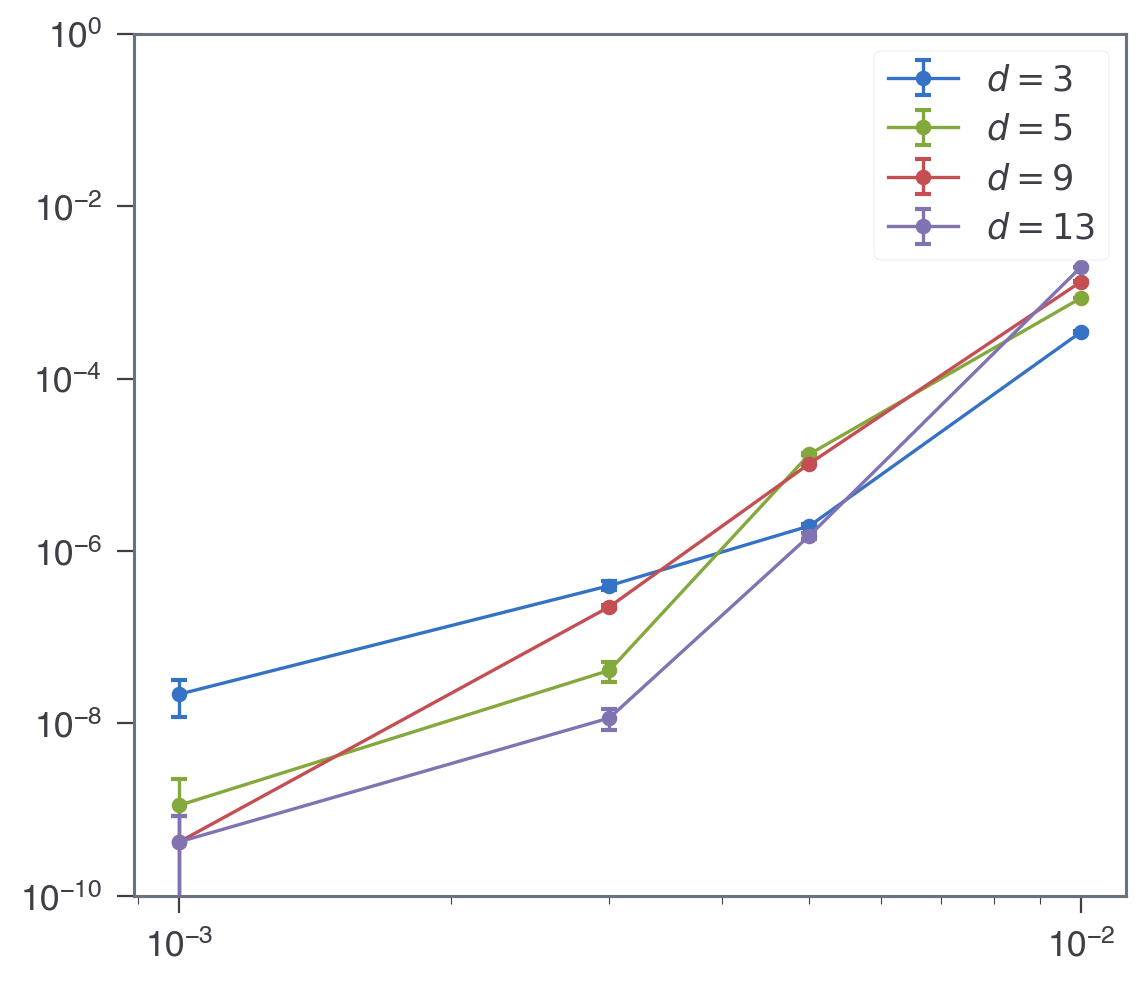

In [254]:
by = "cluster_llr_norm_gap_2"
# by = 'matching_gap'
target_p_abort = 0.5

df_ps = df_ps_dict[by]
dlist = df_ps.index.get_level_values("d").unique()
for i_d, d in enumerate(dlist):
    df_ps_d = df_ps.loc[idx[d, d, :, :], :]
    plist = df_ps_d.index.get_level_values("p").unique()
    pfails = []
    delta_pfails = []
    for i_p, p in enumerate(plist):
        df_ps_dp = df_ps_d.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_dp["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_dp.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_dp.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        plist,
        pfails,
        yerr=delta_pfails,
        label=f"$d={d}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-10, 1)
plt.legend()

## pfail vs d for a fixed abort rate

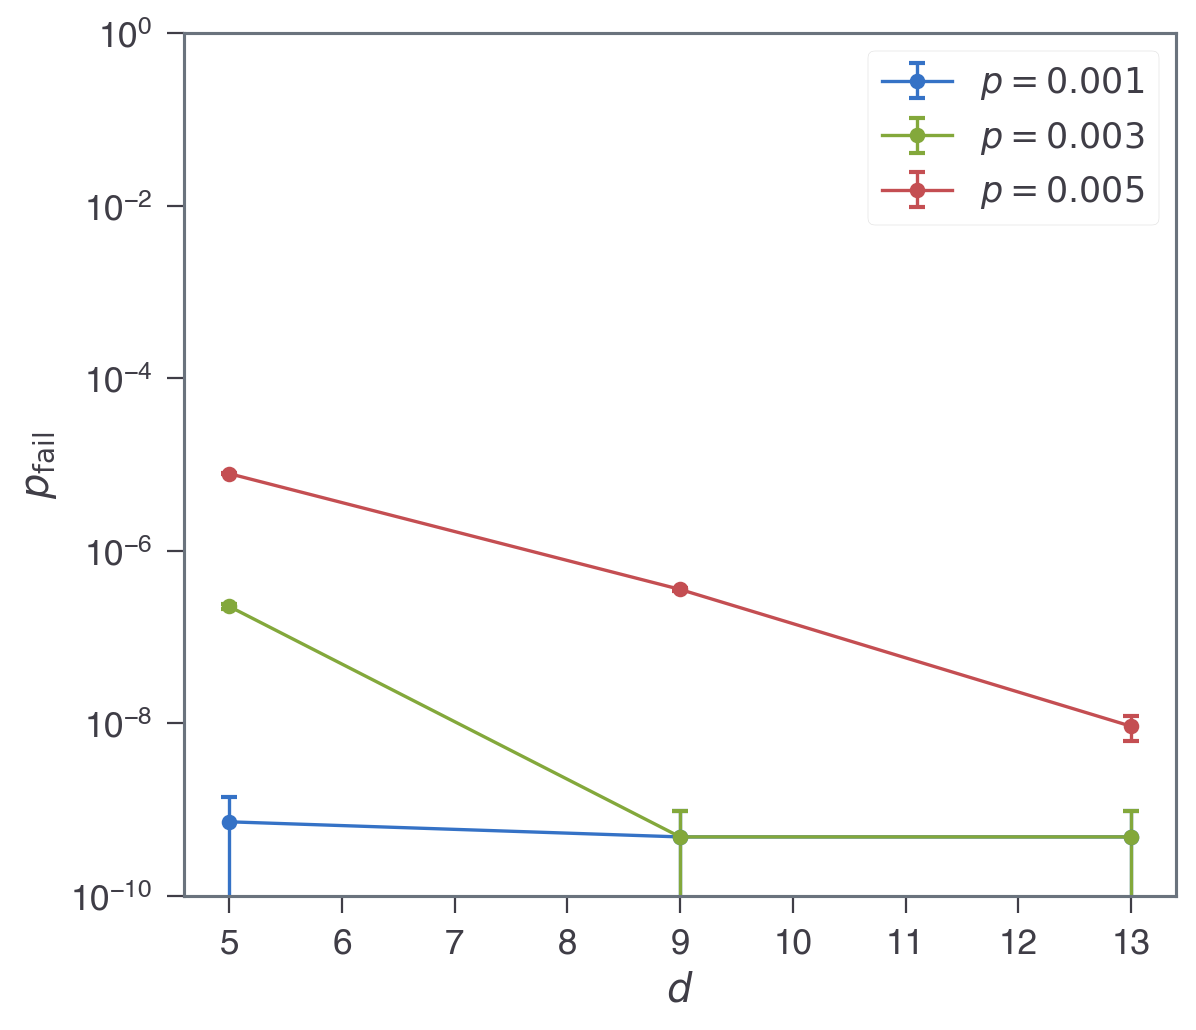

In [104]:
by = "matching_gap"
target_p_abort = 0.2

df_ps = df_ps_dict[by]
plist = df_ps.index.get_level_values("p").unique()
dlist = df_ps.index.get_level_values("d").unique()

for i_p, p in enumerate(plist):
    pfails = []
    delta_pfails = []
    for i_d, d in enumerate(dlist):
        df_ps_d = df_ps.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_d["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_d.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_d.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        dlist,
        pfails,
        yerr=delta_pfails,
        label=f"$p={p}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.ylim(1e-10, 1)
plt.xlabel("$d$")
plt.ylabel("$p_{\\mathrm{fail}}$")
plt.legend()

## Cluster norm distribution

In [257]:
df_agg_dict = load_data(
    ["surface", "surface_matching"], "agg", prefixes=["", "matching_"]
)

<Axes: xlabel='gap', ylabel='Density'>

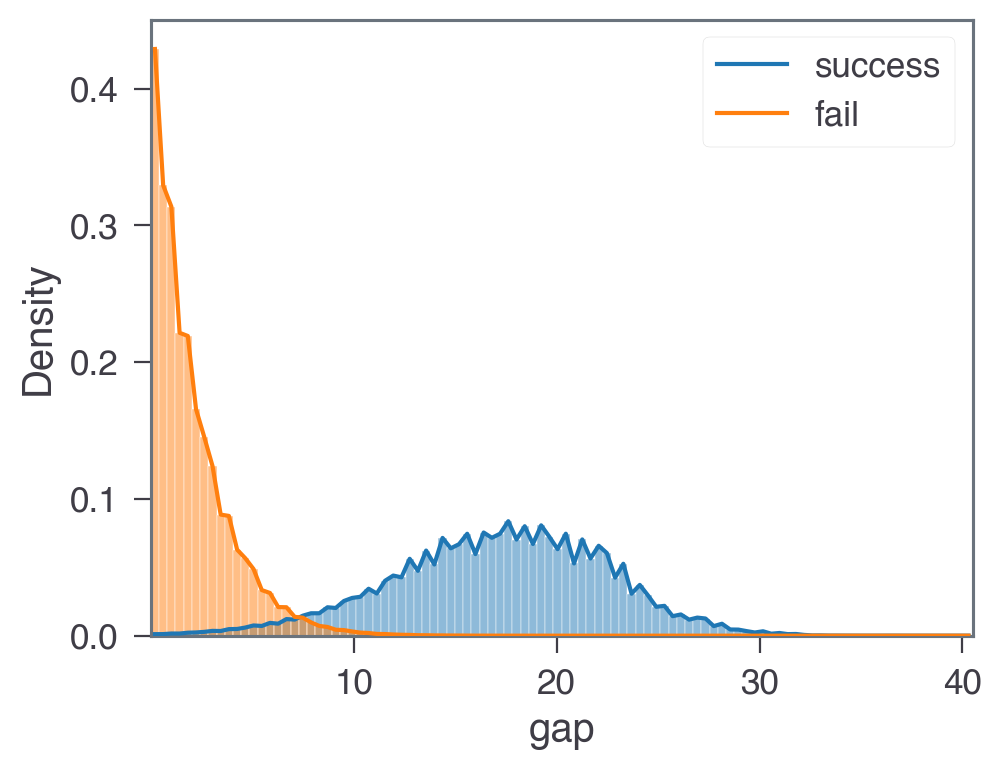

In [327]:
import matplotlib.pyplot as plt
from simulations.analysis.plotting_helpers import plot_success_failure_histogram

# by = "cluster_llr_norm_gap_1"
by = "matching_gap"
d = T = 9
p = 5e-3

df_agg = df_agg_dict[by].loc[(d, T, p)]

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

plot_success_failure_histogram(
    df_agg,
    bins=100,
    colors=[COLORS(0), COLORS(1)],
    # rescale_by_rate=True,
    # twin_y=True,
    alpha=0.5,
    ax=ax,
    lower_trim_frac=1e-2,
)

### Discrimination power

In [192]:
# With aggregated data

from simulations.analysis.plotting_helpers import (
    calculate_discrimination_metrics_from_agg,
)

d = T = 9
p = 5e-3
for by in ["cluster_llr_norm", "cluster_llr_norm_gap"]:
    for norm_order in [0.5, 1, 2, "inf"]:
        by_name = f"{by}_{norm_order}"
        ascending_confidence = True if "gap" in by_name else False

        df_agg = df_agg_dict[by_name].loc[(d, T, p)]
        df_agg["num_succs"] = df_agg["count"] - df_agg["num_fails"]

        auprc_lift = calculate_discrimination_metrics_from_agg(
            metric_values=df_agg.index.values,
            counts=df_agg["count"],
            num_fails=df_agg["num_fails"],
            method="lift",
            ascending_confidence=ascending_confidence,
        )
        print(f"{by_name}: {auprc_lift}")

cluster_llr_norm_0.5: 6.3127126949764
cluster_llr_norm_1: 25.021235866613775
cluster_llr_norm_2: 21.579863260749274
cluster_llr_norm_inf: 20.3559156377191
cluster_llr_norm_gap_0.5: 8.22328092228908
cluster_llr_norm_gap_1: 25.021234558887592
cluster_llr_norm_gap_2: 23.517509632593157
cluster_llr_norm_gap_inf: 22.99702144513394


In [138]:
# With raw data
from simulations.analysis.data_aggregation import extract_sample_metric_values

data_dir = f"../../data/surface_code_minsum_iter30_lsd0/d{d}_T{T}_p{p}"
metric_values = extract_sample_metric_values(
    data_dir=data_dir, by=by, norm_order=norm_order, dtype="float32"
)
fails = extract_sample_metric_values(
    data_dir=data_dir,
    by="fail",
    dtype="bool",
)

Extracting fail values: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


In [140]:
from simulations.analysis.plotting_helpers import (
    calculate_discrimination_metrics_from_raw,
)

calculate_discrimination_metrics_from_raw(
    metric_values=metric_values,
    fails=fails,
    method="auprc",
    ascending_confidence=True,
)

0.0623134526851848

Text(0.5, 0, 'cluster_llr_norm')

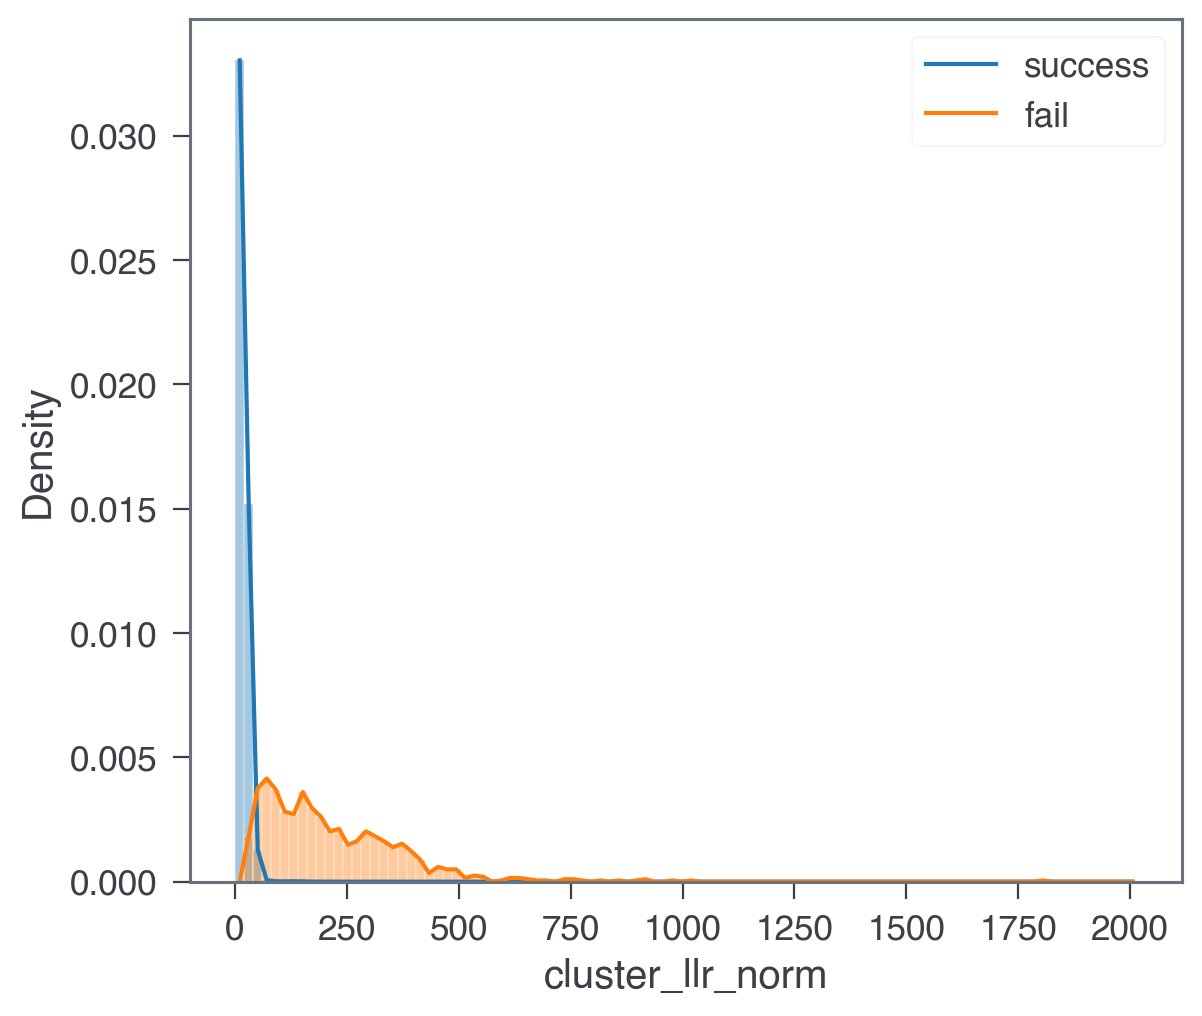

In [178]:
# Find the point where cumulative count reaches "fraction" of total count
total_count = df_agg["count"].sum()
cumsum = df_agg["count"].cumsum()
fraction = 1e-4
threshold_count = total_count * fraction
min_index = df_agg.index[cumsum >= threshold_count].min()
bin_range = (min_index, df_agg.index.max())
bins = 100

by_name = df_agg.index.name

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(0),
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="success",
    color=COLORS(0),
    element="poly",
    linewidth=1.5,
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(1),
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="fail",
    color=COLORS(1),
    element="poly",
    linewidth=1.5,
)
plt.legend()
plt.xlabel(by)